In [1]:
#plotter per unire più run e più posterior
#------------------Import--------------------------------
from scipy import interpolate
from scipy import integrate
import scipy
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import numpy as np
#import healpy as hp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import os 
import statistics as stat
folder='/home/rciancarella/DarkSirensStat/MyDSStat/results/'
#folder='/home/raul/DarkSirensStat/MyDSStat/results/'
os.chdir(folder)

# DS Cat

In [37]:
runpath='0B-Genova-presca-uniform_300'#'Mega450-FullBig_00'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

In [41]:
#all_dls=np.loadtxt(runpath+'_DSs.txt', usecols=2)
os.chdir(datapath)
all_dls=np.loadtxt(runpath+'_DSs.txt', usecols=6)#if there is scattering
all_zs=np.loadtxt(runpath+'_DSs.txt', usecols=3)
dl_max=np.max(all_dls)
dl_min=np.min(all_dls)
dl_med=dl_min+(dl_max-dl_min)/2
idx_max=np.where(all_dls==dl_max)[0][0]
idx_min=np.where(all_dls==dl_min)[0][0]

ref_folder='/home/rciancarella/DarkSirensStat/MyDSStat/'
cat_name='FullExplorer_big.txt'#FullExplorer_big.txt
#datapath=os.path.join(ref_folder,cat_name)
os.chdir(ref_folder)

Uniform_Cat = pd.read_csv(cat_name, sep=" ", header=None)
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
Uniform_Cat.columns=colnames
dlmaxcat=Uniform_Cat['scattered DL'].max()
dlmincat=Uniform_Cat['scattered DL'].min()


outsiders=np.where(all_dls<=dlmincat)[0]
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

idx_med=np.where(all_dls==find_nearest(all_dls, value=dl_med))[0][0]
print(outsiders)
print(idx_min,idx_max,idx_med)

[]
29 144 20


In [58]:
print(dl_max,np.max(all_zs))
print(dl_min,np.min(all_zs))
print(Uniform_Cat['scattered DL'].min(),dl_min)

9989.960863841548 1.7807500428623413
746.5469994425574 0.1570008897790469
170.27815185785596 746.5469994425574


# $\beta$-Plot

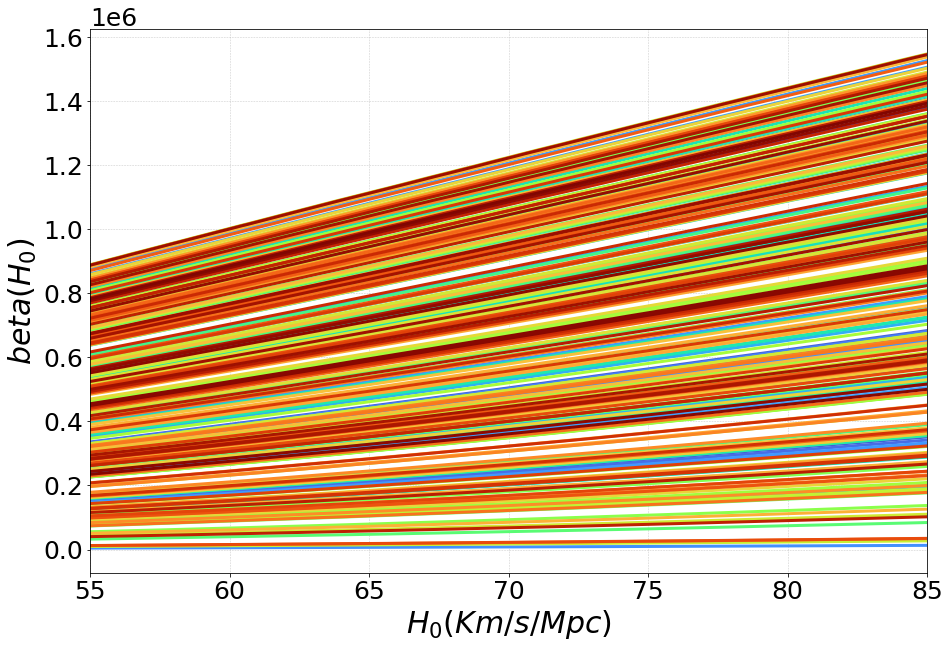

In [43]:
os.chdir(datapath)
x=np.loadtxt(runpath+'_H0grid.txt')
xmin=np.min(x)
xmax=np.max(x)
#betavol=np.loadtxt('/home/rciancarella/DarkSirensStat/MyDSStat/results/volbeta/betatest_beta.txt')
betatest=np.loadtxt(runpath+'_beta.txt')

colors=pl.cm.turbo(np.linspace(0.1,0.99,len(betatest)))
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$beta(H_0)$', fontsize=30)

for i in range(len(betatest)):
    ax.plot(x,betatest[i],color=colors[i],linewidth=3,label='betatest'+str(i))

#ax.plot(x,betatest[idx_max],label='betatest_dlmax',color='r',linewidth=4,linestyle='dashed')
#ax.plot(x,betatest[idx_min],label='betatest_dlmin',color='b',linewidth=4,linestyle='dotted')
#ax.plot(x,betatest[idx_med],label='betatest_dlmed',color='g',linewidth=4,linestyle='solid')
#to_test=betatest[idx_med]/np.trapz(betatest[idx_med],x)
#ax.plot(x,(to_test),label='betatest_dlmed',color='g',linewidth=4,linestyle='solid')
#ax.legend(fontsize=13, ncol=1)    

In [44]:
href=67 #69
Om0GLOB=0.319
Xi0Glob =1.
clight = 2.99792458* 10**5#km/s
from scipy.optimize import fsolve

def E_z(z, Om):
    return np.sqrt(Om*(1+z)**3+(1-Om))

def r_z(z, H0, Om):
    c = clight
    integrand = lambda x : 1/E_z(x, Om)
    integral, error = integrate.quad(integrand, 0, z)
    return integral*c/H0

def Dl_z(z, H0, Om=Om0GLOB):
    return r_z(z, H0, Om)*(1+z)

def zofdl(dl,Htemp,Om=Om0GLOB):
    func = lambda z :Dl_z(z, Htemp, Om) - dl#(mu+s*how_many_sigma*mu)#20944.8#mydlmax#dlmax_sca
    z = fsolve(func, 0.02)[0] 
    return z
#dltilde
def dltilde(z,Om=Om0GLOB):
    c = clight
    integrand = lambda x : 1/E_z(x, Om)
    integral, error = integrate.quad(integrand, 0, z)
    return integral*c*(1+z)
def hsolve(z,dltarget):
    func= lambda h :dltilde(z)/h -dltarget
    hh=fsolve(func,1)[0]
    return hh

In [9]:
dlmax=10000
dlmin=400
print(zofdl(dlmax,href))
print(zofdl(dlmin,href))

1.3638744123452713
0.08417349990959717


# Likelihood

In [59]:
likes=np.loadtxt(runpath +'_fullrun.txt')
NDS=np.shape(likes)[0]
#mybeta=np.loadtxt('/home/rciancarella/DarkSirensStat/MyDSStat/results/MyBeta/MyBeta_beta.txt')

In [56]:
NDS=np.shape(likes)[0]
final_post_by_like=[]
for i in range(NDS):
    final_post_by_like.append(likes[i]/betatest[i])
combined=[]
for i in range(len(final_post_by_like)):
    #combined=combined+post[i]
    if i==0:
        combined.append(final_post_by_like[i]*1)
    else:
        num=np.float128(combined[i-1]*(final_post_by_like[i]*1))
        combined.append(num)
totpost_like=combined[-1]
all_norm_post=[]
for i in range(NDS):
    post=likes[i]/betatest[i]
    post=post/np.trapz(post,x)
    all_norm_post.append(post)


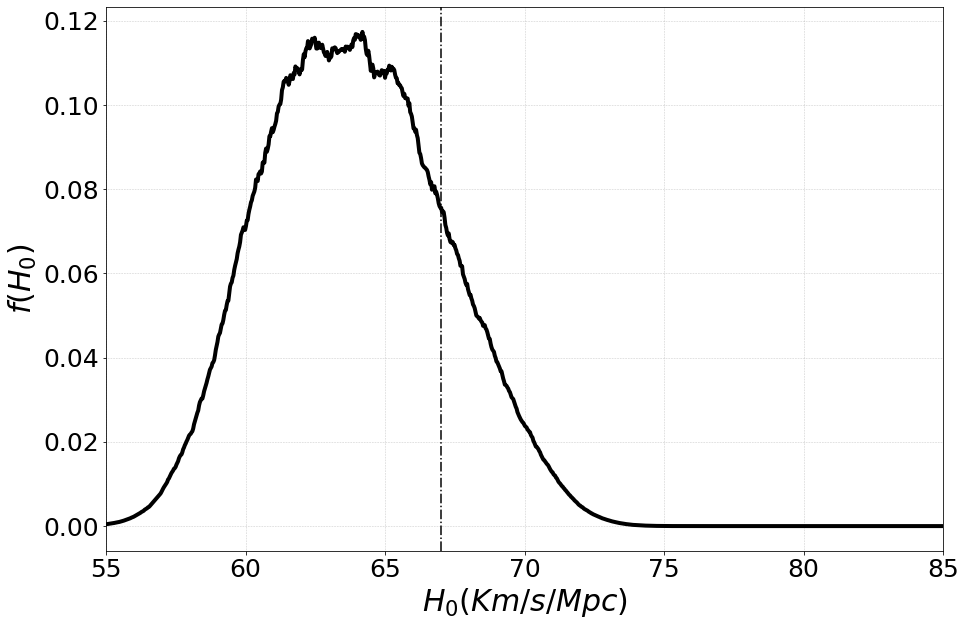

In [57]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$f(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')

#for i in range(NDS):
#    ax.plot(x,likes[i],color=colors[i],linewidth=3)#,label='betatest'+str(i))
    #ax.plot(x,all_norm_post[i],color=colors[i],linewidth=3)#,label='betatest'+str(i))
   #ax.plot(x,combined[i]/np.trapz(combined[i],x),label='Post',color=colors[i],linewidth=3,linestyle='solid')
ax.plot(x,totpost_like/np.trapz(totpost_like,x),label='Post',color='k',linewidth=4,linestyle='solid')
#ax.plot(x,combined[-1]/np.trapz(combined[-1],x),label='Post',color='k',linewidth=4,linestyle='solid')

#------------------------------Single posteriors--------------------------------------
#toplot=likes[idx_max]#/betatest[idx_max]
#ax.plot(x,toplot/np.trapz(toplot,x),label='Post',color='r',linewidth=4,linestyle='dashed')

#toplot=likes[idx_med]#/betatest[idx_med]
#ax.plot(x,toplot/np.trapz(toplot,x),label='Post',color='g',linewidth=4,linestyle='solid')

#toplot=likes[idx_min]#/betatest[idx_min]
#ax.plot(x,toplot/np.trapz(toplot,x),label='Post',color='b',linewidth=4,linestyle='dotted')

In [48]:
#all_dls
#all_zs
href=67
zmin=0.4
zsfr=1
zmax=1.35
dlmax = 10000
dlmin = 400
mezzo_delta=(dlmax-dlmin)/2
dlmed=dlmin+mezzo_delta#5125

idx_first=np.where(all_dls<=dlmed)[0]
idx_second=np.where(all_dls>dlmed)[0]

In [49]:
tmplikes=likes[idx_first]
tmpbeta=betatest[idx_first]
tmpNDS=np.shape(tmplikes)[0]
tmpfinal_post_by_like=[]
for i in range(tmpNDS):
    tmpfinal_post_by_like.append(tmplikes[i]/tmpbeta[i])
combined=[]
for i in range(len(tmpfinal_post_by_like)):
    #combined=combined+post[i]
    if i==0:
        combined.append(tmpfinal_post_by_like[i]*1)
    else:
        num=np.float128(combined[i-1]*(tmpfinal_post_by_like[i]*1))
        combined.append(num)
totpost_like1=combined[-1]


    
tmplikes=likes[idx_second]
tmpbeta=betatest[idx_second]
tmpNDS=np.shape(tmplikes)[0]
tmpfinal_post_by_like=[]
for i in range(tmpNDS):
    tmpfinal_post_by_like.append(tmplikes[i]/tmpbeta[i])
combined=[]
for i in range(len(tmpfinal_post_by_like)):
    #combined=combined+post[i]
    if i==0:
        combined.append(tmpfinal_post_by_like[i]*1)
    else:
        num=np.float128(combined[i-1]*(tmpfinal_post_by_like[i]*1))
        combined.append(num)
totpost_like2=combined[-1]

mytot=totpost_like1*totpost_like2

mean=64.4771400559351,std=3.2908493339496125 std/mean=5.103900903629939%
mean=63.93011156623489,std=4.2815149758270525 std/mean=6.697180516244185%
mean=65.16010405536109,std=3.9042805485871566 std/mean=5.991826755325645%


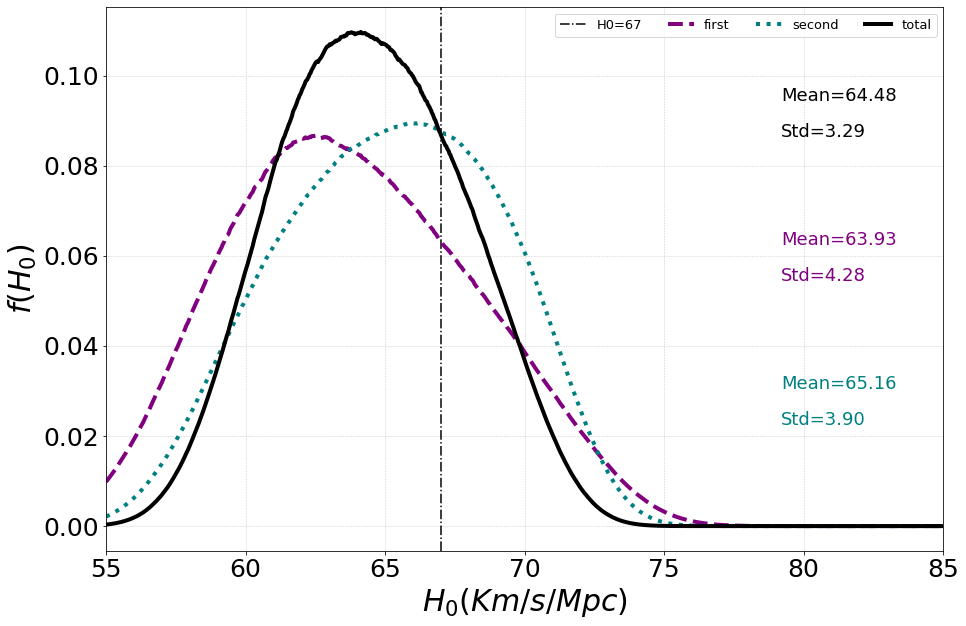

In [50]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$f(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')

#for i in range(NDS):
#    ax.plot(x,likes[i],color=colors[i],linewidth=3)#,label='betatest'+str(i))
ax.plot(x,totpost_like1/np.trapz(totpost_like1,x),label='first',color='purple',linewidth=4,linestyle='dashed')
ax.plot(x,totpost_like2/np.trapz(totpost_like2,x),label='second',color='teal',linewidth=4,linestyle='dotted')
ax.plot(x,totpost_like/np.trapz(totpost_like,x),label='total',color='k',linewidth=4,linestyle='solid')
#ax.plot(x,mytot/np.trapz(mytot,x),label='total',color='r',linewidth=4,linestyle='solid')


ax.legend(fontsize=13, ncol=4)   
dist=(totpost_like)/np.trapz(totpost_like,x)
mean=np.trapz(x*dist,x)/np.trapz(dist,x)
std=np.sqrt(np.trapz(dist*(x-mean)**2,x)/np.trapz(dist,x))
plt.figtext(0.75,0.75,'Mean={:0.2f}'.format(mean),fontsize=18,c='k')
plt.figtext(0.75,0.70,'Std={:0.2f}'.format(std),fontsize=18, c='k')
print('mean={},std={} std/mean={}%'.format(mean,std,100*std/mean))


dist=(totpost_like1)/np.trapz(totpost_like1,x)
mean=np.trapz(x*dist,x)/np.trapz(dist,x)
std=np.sqrt(np.trapz(dist*(x-mean)**2,x)/np.trapz(dist,x))
plt.figtext(0.75,0.55,'Mean={:0.2f}'.format(mean),fontsize=18,c='purple')
plt.figtext(0.75,0.50,'Std={:0.2f}'.format(std),fontsize=18, c='purple')
print('mean={},std={} std/mean={}%'.format(mean,std,100*std/mean))

dist=(totpost_like2)/np.trapz(totpost_like2,x)
mean=np.trapz(x*dist,x)/np.trapz(dist,x)
std=np.sqrt(np.trapz(dist*(x-mean)**2,x)/np.trapz(dist,x))
plt.figtext(0.75,0.35,'Mean={:0.2f}'.format(mean),fontsize=18,c='teal')
plt.figtext(0.75,0.30,'Std={:0.2f}'.format(std),fontsize=18, c='teal')
print('mean={},std={} std/mean={}%'.format(mean,std,100*std/mean))

Use a different boundary for beta

In [51]:
from multiprocessing import Pool
import multiprocessing
from numba import njit
from tqdm import tqdm

allz=np.asarray(Uniform_Cat['z'])
H0Grid=x
arr=np.arange(0,len(H0Grid),dtype=int)


dlmax = 10000
dlmin = 400
mezzo_delta=(dlmax-dlmin)/2
dlmed=dlmin+mezzo_delta#5125

In [52]:
def multibetaline(iterator):
    i=iterator
    Htemp=H0Grid[i]
    func = lambda z :Dl_z(z, Htemp, Om0GLOB) - mydlmax#(mu+s*how_many_sigma*mu)#20944.8#mydlmax#dlmax_sca
    zMax = fsolve(func, 0.02)[0] 
    #zMax=min(zMax,zmax_cat)
    
    func = lambda z :Dl_z(z, Htemp, Om0GLOB) - mydlmin#(mu-s*how_many_sigma*mu)#232.077#mydlmin#dlmin_sca
    zmin = fsolve(func, 0.02)[0]

    tmp=allz[allz>=zmin] # host with z>z_min
    tmp=tmp[tmp<=zMax]  # host with z_min<z<z_max
    
    gal_invol=(len(tmp))
    if gal_invol==0:
        gal_invol=gal_invol+1

    ret=gal_invol#/gal_incat
    return ret 

In [53]:
#--------------first half
mydlmin=dlmin
mydlmax=dlmax
with Pool(14) as p:
    beta=p.map(multibetaline, arr)
beta1=np.asarray(beta)
#--------------second half
mydlmin=dlmed
mydlmax=dlmax
with Pool(14) as p:
    beta=p.map(multibetaline, arr)
beta2=np.asarray(beta)

In [54]:
tmplikes=likes[idx_first]
tmpNDS=np.shape(tmplikes)[0]
tmpfinal_post_by_like=[]
for i in range(NDS):
    tmpfinal_post_by_like.append(likes[i]/beta1)
combined=[]
for i in range(len(tmpfinal_post_by_like)):
    #combined=combined+post[i]
    if i==0:
        combined.append(tmpfinal_post_by_like[i]*1)
    else:
        num=np.float128(combined[i-1]*(tmpfinal_post_by_like[i]*1))
        combined.append(num)
totpost_like1=combined[-1]

    
tmplikes=likes[idx_second]
tmpNDS=np.shape(tmplikes)[0]
tmpfinal_post_by_like=[]
for i in range(tmpNDS):
    tmpfinal_post_by_like.append(tmplikes[i]/beta2)
combined=[]
for i in range(len(tmpfinal_post_by_like)):
    #combined=combined+post[i]
    if i==0:
        combined.append(tmpfinal_post_by_like[i]*1)
    else:
        num=np.float128(combined[i-1]*(tmpfinal_post_by_like[i]*1))
        combined.append(num)
totpost_like2=combined[-1]

mytot=totpost_like1*totpost_like2

mean=64.4771400559351,std=3.2908493339496125 std/mean=5.103900903629939%
mean=63.89644231167922,std=3.162514630757862 std/mean=4.949437740729747%
mean=65.1023088349648,std=3.771942618413426 std/mean=5.793869197443288%


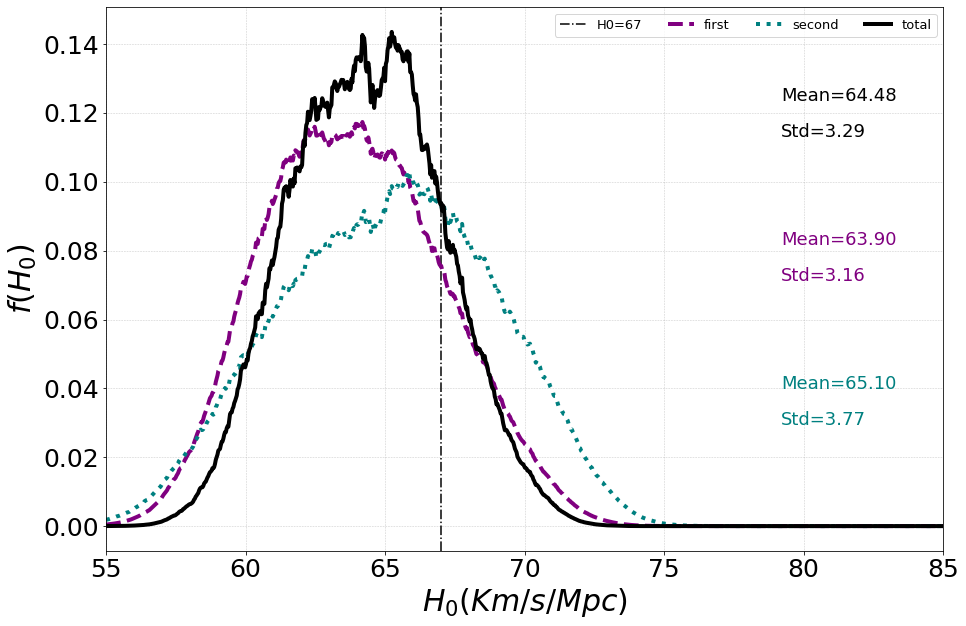

In [55]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$f(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')

#for i in range(NDS):
#    ax.plot(x,likes[i],color=colors[i],linewidth=3)#,label='betatest'+str(i))
ax.plot(x,totpost_like1/np.trapz(totpost_like1,x),label='first',color='purple',linewidth=4,linestyle='dashed')
ax.plot(x,totpost_like2/np.trapz(totpost_like2,x),label='second',color='teal',linewidth=4,linestyle='dotted')
ax.plot(x,mytot/np.trapz(mytot,x),label='total',color='k',linewidth=4,linestyle='solid')

ax.legend(fontsize=13, ncol=4)   
dist=(totpost_like)/np.trapz(totpost_like,x)
mean=np.trapz(x*dist,x)/np.trapz(dist,x)
std=np.sqrt(np.trapz(dist*(x-mean)**2,x)/np.trapz(dist,x))
plt.figtext(0.75,0.75,'Mean={:0.2f}'.format(mean),fontsize=18,c='k')
plt.figtext(0.75,0.70,'Std={:0.2f}'.format(std),fontsize=18, c='k')
print('mean={},std={} std/mean={}%'.format(mean,std,100*std/mean))


dist=(totpost_like1)/np.trapz(totpost_like1,x)
mean=np.trapz(x*dist,x)/np.trapz(dist,x)
std=np.sqrt(np.trapz(dist*(x-mean)**2,x)/np.trapz(dist,x))
plt.figtext(0.75,0.55,'Mean={:0.2f}'.format(mean),fontsize=18,c='purple')
plt.figtext(0.75,0.50,'Std={:0.2f}'.format(std),fontsize=18, c='purple')
print('mean={},std={} std/mean={}%'.format(mean,std,100*std/mean))

dist=(totpost_like2)/np.trapz(totpost_like2,x)
mean=np.trapz(x*dist,x)/np.trapz(dist,x)
std=np.sqrt(np.trapz(dist*(x-mean)**2,x)/np.trapz(dist,x))
plt.figtext(0.75,0.35,'Mean={:0.2f}'.format(mean),fontsize=18,c='teal')
plt.figtext(0.75,0.30,'Std={:0.2f}'.format(std),fontsize=18, c='teal')
print('mean={},std={} std/mean={}%'.format(mean,std,100*std/mean))

# From Posterior

In [ ]:
#post=np.loadtxt(runpath+'_totpost.txt')

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Posterior(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')

Mycol='navy'
Myshift='deeppink'
#ax.plot(x,post/np.trapz(post,x),label='Post',color=Mycol,linewidth=4,linestyle='solid')
#ax.plot(x,totpost_like/np.trapz(totpost_like,x),label='Post',color=Myshift,linewidth=4,linestyle='solid')

toplot=likes[idx_max]/betatest[idx_max]
ax.plot(x,toplot/np.trapz(toplot,x),label='Post',color='r',linewidth=4,linestyle='dashed')
post_max=toplot
toplot=likes[idx_med]/betatest[idx_med]
ax.plot(x,toplot/np.trapz(toplot,x),label='Post',color='g',linewidth=4,linestyle='solid')
post_med=toplot
toplot=likes[idx_min]/betatest[idx_min]
ax.plot(x,toplot/np.trapz(toplot,x),label='Post',color='b',linewidth=4,linestyle='dotted')
post_min=toplot

ax.plot(x,totpost_like/np.trapz(totpost_like,x),label='Post',color='purple',linewidth=4,linestyle='-.')

test=post_min*post_med*post_max
ax.plot(x,test/np.trapz(test,x),label='Post',color='k',linewidth=4,linestyle='-.')

newdist=(test)/np.trapz(test,x)
mean=np.trapz(x*newdist,x)/np.trapz(newdist,x)
std=np.sqrt(np.trapz(newdist*(x-mean)**2,x)/np.trapz(newdist,x))
plt.figtext(0.75,0.6,'Mean={:0.2f}'.format(mean),fontsize=18,c=Mycol)
plt.figtext(0.75,0.55,'Std={:0.2f}'.format(std),fontsize=18, c=Mycol)
print('mean={},std={} std/mean={}%'.format(mean,std,100*std/mean))

dist=(totpost_like)/np.trapz(totpost_like,x)
mean=np.trapz(x*dist,x)/np.trapz(dist,x)
std=np.sqrt(np.trapz(dist*(x-mean)**2,x)/np.trapz(dist,x))
plt.figtext(0.75,0.45,'Mean={:0.2f}'.format(mean),fontsize=18,c=Myshift)
plt.figtext(0.75,0.40,'Std={:0.2f}'.format(std),fontsize=18, c=Myshift)
print('mean={},std={} std/mean={}%'.format(mean,std,100*std/mean))

os.chdir(datapath)
#plt.savefig('PlotTot.pdf', format="pdf", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Posterior(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')
for i in range(NDS):
    mypost=likes[i]/betatest[i]
    ax.plot(x,mypost/np.trapz(mypost,x),color=colors[i],linewidth=3)#,label='betatest'+str(i))

In [ ]:
half=np.longdouble(normed_0*normed_1)

# Remove big Scattering

In [ ]:
DS_Cat = pd.read_csv(runpath+'_DSs.txt', sep=" ", header=None)
if DS_Cat.shape[1]==6:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
if DS_Cat.shape[1]==7:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
DS_Cat.columns=colnames
print(DS_Cat.shape[0])

In [ ]:
np.mean(DS_Cat['scattered DL'])

In [ ]:
np.mean(DS_Cat['Luminosity Distance'])

In [ ]:
sigma=DS_Cat['Luminosity Distance']*0.1
sigmadist=(DS_Cat['Luminosity Distance']-DS_Cat['scattered DL'])/sigma
sigmadist_abs=np.absolute(sigmadist)
towork=DS_Cat
towork['sigma_dist']=sigmadist
towork=towork[towork['sigma_dist']<=1]
towork=towork[towork['sigma_dist']>=-1]
print(towork.shape[0],DS_Cat.shape[0],towork.shape[0]/DS_Cat.shape[0])
temp=np.where(sigmadist_abs<1)[0]

In [ ]:
beta_filtered=betatest[temp]
like_filtered=likes[temp]

In [ ]:
NDS=np.shape(like_filtered)[0]
final_post_filtered=[]
for i in range(NDS):
    final_post_filtered.append(like_filtered[i]/beta_filtered[i])
combined_filtered=[]
for i in range(len(final_post_filtered)):
    #combined=combined+post[i]
    if i==0:
        combined_filtered.append(final_post_filtered[i])
    else:
        num=np.float128(combined_filtered[i-1]*(final_post_filtered[i]))
        combined_filtered.append(num)
totpost_filtered=combined_filtered[-1]
all_norm_filtered=[]
for i in range(NDS):
    post_filtered=like_filtered[i]/beta_filtered[i]
    post_filtered=post_filtered/np.trapz(post_filtered,x)
    all_norm_filtered.append(post)

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Posterior(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')
selcol=pl.cm.turbo(np.linspace(0.1,0.99,len(like_filtered)))
for i in range(40,45):
    mypost=like_filtered[i]/beta_filtered[i]
    ax.plot(x,mypost/np.trapz(mypost,x),color=selcol[i**2-1707],linewidth=3,label=str(i))
    #ax.plot(x,combined_filtered[i]/np.trapz(combined_filtered[i],x),color=selcol[i],linewidth=3)
    #ax.plot(x,beta_filtered[i],color=selcol[i*5+20],linewidth=3,label=str(i))
    #ax.plot(x,likes[i]/1/np.trapz(likes[i]/1,x),color=selcol[i**2-1707],linewidth=3,label=str(i))
#ax.plot(x,totpost_filtered/np.trapz(totpost_filtered,x),color='teal',linewidth=3)
ax.legend(fontsize=13, ncol=1)   

In [ ]:
towork[40:45]

# Close Study 

In [ ]:
import pandas as pd

In [ ]:
DS_Cat = pd.read_csv(runpath+'_DSs.txt', sep=" ", header=None)
if DS_Cat.shape[1]==6:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
if DS_Cat.shape[1]==7:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
DS_Cat.columns=colnames
print(DS_Cat.shape[0])

In [ ]:
DS_Cat.head(3)

In [ ]:
selected=DS_Cat[DS_Cat['z']>=2]
print(selected.shape[0])
selected.head()

In [ ]:
myselection=np.asarray(selected.index.values)

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$beta(H_0)$', fontsize=30)
for i in myselection:
    ax.plot(x,betatest[i],linewidth=3,label='betatest'+str(i))
#ax.plot(x,betatest[idx_max],label='betatest_dlmax',color='r',linewidth=4,linestyle='dashed')

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Posterior(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')
for i in myselection:
    toplot=likes[i]
    ax.plot(x,toplot/np.trapz(toplot,x),linewidth=3)
    

In [ ]:
for i in myselection:
    final_post_by_like.append(likes[i]/betatest[i])
combined=[]
for i in range(len(final_post_by_like)):
    #combined=combined+post[i]
    if i==0:
        combined.append(final_post_by_like[i]*1)
    else:
        num=np.float128(combined[i-1]*(final_post_by_like[i]*1))
        combined.append(num)
totpost_like=combined[-1]

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Posterior(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')
ax.plot(x,totpost_like/np.trapz(totpost_like,x),label='Post',color='k',linewidth=4,linestyle='solid')

newdist=(totpost_like)/np.trapz(totpost_like,x)
mean=np.trapz(x*newdist,x)/np.trapz(newdist,x)
std=np.sqrt(np.trapz(newdist*(x-mean)**2,x)/np.trapz(newdist,x))
plt.figtext(0.75,0.6,'Mean={:0.2f}'.format(mean),fontsize=18,c=Mycol)
plt.figtext(0.75,0.55,'Std={:0.2f}'.format(std),fontsize=18, c=Mycol)

In [ ]:
selected=DS_Cat[DS_Cat['z']<=1]
print(selected.shape[0])
selected.head()

In [ ]:
myselection=np.asarray(selected.index.values)

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$beta(H_0)$', fontsize=30)
for i in myselection:
    ax.plot(x,betatest[i],linewidth=3,label='betatest'+str(i))
#ax.plot(x,betatest[idx_min],label='betatest_dlmin',color='b',linewidth=4,linestyle='dotted')

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Posterior(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')
myselection_new= np.delete(myselection,[22])
for i in myselection:
    toplot=likes[i]
    ax.plot(x,toplot/np.trapz(toplot,x),linewidth=3)

In [ ]:
for i in myselection:
    final_post_by_like.append(likes[i]/betatest[i])
combined=[]
for i in range(len(final_post_by_like)):
    #combined=combined+post[i]
    if i==0:
        combined.append(final_post_by_like[i]*1)
    else:
        num=np.float128(combined[i-1]*(final_post_by_like[i]*1))
        combined.append(num)
totpost_like=combined[-1]

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Posterior(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')
ax.plot(x,totpost_like/np.trapz(totpost_like,x),label='Post',color='k',linewidth=4,linestyle='solid')

newdist=(totpost_like)/np.trapz(totpost_like,x)
mean=np.trapz(x*newdist,x)/np.trapz(newdist,x)
std=np.sqrt(np.trapz(newdist*(x-mean)**2,x)/np.trapz(newdist,x))
plt.figtext(0.75,0.6,'Mean={:0.2f}'.format(mean),fontsize=18,c=Mycol)
plt.figtext(0.75,0.55,'Std={:0.2f}'.format(std),fontsize=18, c=Mycol)

# Scatter

In [ ]:
import pandas as pd

In [ ]:
scatter_runpath='Mega450-FullBig_00'#'P0_postback-scatter'#runpath
scatter_datapath=os.path.join(folder,scatter_runpath)
os.chdir(scatter_datapath)
print(scatter_datapath)

In [ ]:
DS_Cat = pd.read_csv(scatter_runpath+'_DSs.txt', sep=" ", header=None)
if DS_Cat.shape[1]==6:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
    print('Dataframe has no Scatter')
if DS_Cat.shape[1]==7:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
DS_Cat.columns=colnames
print(DS_Cat.shape[0])

In [ ]:
truedl=DS_Cat['Luminosity Distance']
scattereddl=DS_Cat['scattered DL']
diff=truedl-scattereddl
allsigma=0.1*truedl

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))


nbins=30
(n, bins, patches)=ax.hist(diff,bins=nbins,range=(np.min(diff),np.max(diff)),rwidth=0.95)

ax.set_xlabel(r'$dl true-dl scatter$', fontsize=20)
ax.set_ylabel(r'$N$', fontsize=20)

In [ ]:
mean=np.mean(diff)
std=np.std(diff)
print(mean,std)

In [ ]:
norm_diff=diff/allsigma
print(np.mean(norm_diff))
test=norm_diff[norm_diff>=-1]
test=test[test<=1]
print(len(test)/len(norm_diff))

In [ ]:
print(allsigma[0],diff[0],truedl[0])

In [ ]:
norm_diff=norm_diff-np.mean(norm_diff)
print(np.mean(norm_diff))
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))


nbins=30
(n_norm, bins_norm, patches)=ax.hist(norm_diff,bins=nbins,
                                     range=(-5,5),rwidth=0.96)

ax.set_xlabel(r'$(dl true-dl scatter) / Sigma$', fontsize=20)
ax.set_ylabel(r'$N$', fontsize=20)

In [ ]:
mean=np.mean(norm_diff)
std=np.std(norm_diff)
median=np.median(norm_diff)
print(mean,std,median)
skw=3*(mean-median)/std
print(skw)

In [ ]:
dl=np.linspace(1000,30000,60000)
scat=np.zeros(len(dl))
mysigma=dl*0.1
for i in range(len(dl)):
    scat[i]=np.random.normal(loc=dl[i], scale=mysigma[i], size=None)

In [ ]:
mydiff=dl-scat
mynormdiff=mydiff/mysigma

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))


nbins=30
(n, bins, patches)=ax.hist(mydiff,bins=nbins,range=(np.min(mydiff),np.max(mydiff)))

ax.set_xlabel(r'$dl true-dl scatter$', fontsize=20)
ax.set_ylabel(r'$N$', fontsize=20)

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))


nbins=60
(n_norm, bins_norm, patches)=ax.hist(mynormdiff,bins=nbins,range=(np.min(mynormdiff),np.max(mynormdiff)),
                                     density=False,color='teal')
rectangle=[]
for i in range(len(bins_norm)-1):
    base=bins_norm[i+1]-bins_norm[i]
    tmp=base*n_norm[i]
    rectangle.append(tmp)
nn=np.sum(rectangle)
print(nn)
dens=np.sum(n_norm)*np.diff(bins_norm)

#mymax=np.max(n_norm)
#mynorm=mymax_nonorm/mymax



In [ ]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))
nbins=60
(n_norm, bins_norm, patches)=ax.hist(mynormdiff,bins=nbins,range=(np.min(mynormdiff),np.max(mynormdiff)),
                                     density=True,color='teal')

gg=lambda x: np.exp(-(x**2)/2)*(1/np.sqrt(2*np.pi))
xsigma_min=np.min(bins_norm)
xsigma_max=np.max(bins_norm)
halfstep=(bins_norm[1]-bins_norm[0])/2
mypoints=bins_norm[0:-1]+halfstep
ax.plot(mypoints,gg(mypoints),color='k')

ax.errorbar(mypoints,n_norm,yerr=np.sqrt(n_norm/nn),fmt='o',color='indigo')
ax.set_xlabel(r'$dl true-dl scatter$', fontsize=20)
ax.set_ylabel(r'$N$', fontsize=20)

In [ ]:
mean=np.mean(mydiff)
std=np.std(mydiff)
print(mean,std)
print('Prop. of normed hist\n Mean\t std\t Median')
mean=np.mean(mynormdiff)
std=np.std(mynormdiff)
median=np.median(mynormdiff)
print(mean,std,median)
skw=3*(mean-median)/std
print(skw)

In [ ]:
test=mynormdiff[mynormdiff>=-1]
test=test[test<=1]
print(len(test)/len(mynormdiff))
test=mynormdiff[mynormdiff>=-2]
test=test[test<=2]
print(len(test)/len(mynormdiff))
test=mynormdiff[mynormdiff>=-3]
test=test[test<=3]
print(len(test)/len(mynormdiff))


In [ ]:
mynormdiff=mynormdiff-mean

fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))


nbins=60
(n_norm, bins_norm, patches)=ax.hist(mynormdiff,bins=nbins,range=(np.min(mynormdiff),np.max(mynormdiff)),
                                     density=False,color='teal')
rectangle=[]
for i in range(len(bins_norm)-1):
    base=bins_norm[i+1]-bins_norm[i]
    tmp=base*n_norm[i]
    rectangle.append(tmp)
nn=np.sum(rectangle)
print(nn)
dens=np.sum(n_norm)*np.diff(bins_norm)

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))
nbins=60
(n_norm, bins_norm, patches)=ax.hist(mynormdiff,bins=nbins,range=(np.min(mynormdiff),np.max(mynormdiff)),
                                     density=True,color='teal')

gg=lambda x: np.exp(-(x**2)/2)*(1/np.sqrt(2*np.pi))
xsigma_min=np.min(bins_norm)
xsigma_max=np.max(bins_norm)
halfstep=(bins_norm[1]-bins_norm[0])/2
mypoints=bins_norm[0:-1]+halfstep
ax.plot(mypoints,gg(mypoints),color='k')

ax.errorbar(mypoints,n_norm,yerr=np.sqrt(n_norm/nn),fmt='o',color='indigo')
ax.set_xlabel(r'$dl true-dl scatter$', fontsize=20)
ax.set_ylabel(r'$N$', fontsize=20)

In [ ]:
mean=np.mean(mynormdiff)
std=np.std(mynormdiff)
median=np.median(mynormdiff)
print(mean,std,median)

test=mynormdiff[mynormdiff>=-1]
test=test[test<=1]
print(len(test)/len(mynormdiff))
test=mynormdiff[mynormdiff>=-2]
test=test[test<=2]
print(len(test)/len(mynormdiff))
test=mynormdiff[mynormdiff>=-3]
test=test[test<=3]
print(len(test)/len(mynormdiff))
skw=3*(mean-median)/std
print(skw)
print(scipy.stats.kurtosis(mynormdiff))


# Confronto Cataloghi DS

In [ ]:
#----------Run singola 450--------------------------------
import pandas as pd
runpath='BorderCheck_FullBig_00'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

Mega = pd.read_csv(runpath+'_DSs.txt', sep=" ", header=None)
if Mega.shape[1]==6:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
if Mega.shape[1]==7:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
Mega.columns=colnames
#---------------prima run omogenea sottostima
runpath='EnzoTest_00'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

sotto_00 = pd.read_csv(runpath+'_DSs.txt', sep=" ", header=None)
if sotto_00.shape[1]==6:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
if sotto_00.shape[1]==7:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
sotto_00.columns=colnames

runpath='EnzoTest_01'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

sotto_01 = pd.read_csv(runpath+'_DSs.txt', sep=" ", header=None)
if sotto_01.shape[1]==6:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
if sotto_01.shape[1]==7:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
sotto_01.columns=colnames

runpath='EnzoTest_02'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

sotto_02 = pd.read_csv(runpath+'_DSs.txt', sep=" ", header=None)
if sotto_02.shape[1]==6:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
if sotto_02.shape[1]==7:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
sotto_02.columns=colnames

sotto_tot=pd.DataFrame(columns=colnames)
sotto_tot = pd.concat([sotto_00, sotto_01,sotto_02], ignore_index=True)

#Mega.head()
#sotto_tot.head()

print(Mega.shape,sotto_tot.shape)

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

nbins=20
(n_mega, bins_mega, patches)=ax.hist(Mega['Comoving Distance'],bins=nbins,range=(np.min(Mega['Comoving Distance']),np.max(Mega['Comoving Distance'])),
                                     density=False,color='teal',linestyle='solid',lw=4,alpha=0.9, edgecolor = 'k')

(n_sotto, bins_sotto, patches)=ax.hist(sotto_tot['Comoving Distance'],bins=nbins,range=(np.min(Mega['Comoving Distance']),np.max(Mega['Comoving Distance'])),
                                     density=False,color='purple',linestyle='--',lw=4,alpha=0.5, edgecolor = 'r')

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

nbins=20
(n_mega, bins_mega, patches)=ax.hist(Mega['Luminosity Distance'],bins=nbins,range=(np.min(Mega['Luminosity Distance']),np.max(Mega['Luminosity Distance'])),
                                     density=False,color='teal',linestyle='solid',lw=4,alpha=0.9, edgecolor = 'k')

(n_sotto, bins_sotto, patches)=ax.hist(sotto_tot['Luminosity Distance'],bins=nbins,range=(np.min(Mega['Luminosity Distance']),np.max(Mega['Luminosity Distance'])),
                                     density=False,color='purple',linestyle='--',lw=4,alpha=0.5, edgecolor = 'r')

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

nbins=20
(n_mega, bins_mega, patches)=ax.hist(Mega['scattered DL'],bins=nbins,range=(np.min(Mega['scattered DL']),np.max(Mega['scattered DL'])),
                                     density=False,color='teal',linestyle='solid',lw=4,alpha=0.9, edgecolor = 'k')

(n_sotto, bins_sotto, patches)=ax.hist(sotto_tot['scattered DL'],bins=nbins,range=(np.min(Mega['scattered DL']),np.max(Mega['scattered DL'])),
                                     density=False,color='purple',linestyle='--',lw=4,alpha=0.5, edgecolor = 'r')

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

nbins=20
(n_mega, bins_mega, patches)=ax.hist(Mega['z'],bins=nbins,range=(np.min(Mega['z']),np.max(Mega['z'])),
                                     density=False,color='teal',linestyle='solid',lw=4,alpha=0.9, edgecolor = 'k')

(n_sotto, bins_sotto, patches)=ax.hist(sotto_tot['z'],bins=nbins,range=(np.min(Mega['z']),np.max(Mega['z'])),
                                     density=False,color='purple',linestyle='--',lw=4,alpha=0.5, edgecolor = 'r')

In [ ]:
#----------Run singola 450--------------------------------
import pandas as pd
runpath='P0_postback'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

ref = pd.read_csv(runpath+'_DSs.txt', sep=" ", header=None)
if ref.shape[1]==6:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
if ref.shape[1]==7:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
ref.columns=colnames

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

nbins=20
(n_ref, bins_ref, patches)=ax.hist(ref['Comoving Distance'],bins=nbins,range=(np.min(Mega['Comoving Distance']),np.max(Mega['Comoving Distance'])),
                                     density=True,color='limegreen',linestyle='dotted',lw=4,alpha=0.9, edgecolor = 'green')

(n_mega, bins_mega, patches)=ax.hist(Mega['Comoving Distance'],bins=nbins,range=(np.min(Mega['Comoving Distance']),np.max(Mega['Comoving Distance'])),
                                     density=True,color='teal',linestyle='solid',lw=4,alpha=0.5, edgecolor = 'k')

(n_sotto, bins_sotto, patches)=ax.hist(sotto_tot['Comoving Distance'],bins=nbins,range=(np.min(Mega['Comoving Distance']),np.max(Mega['Comoving Distance'])),
                                     density=True,color='purple',linestyle='--',lw=4,alpha=0.5, edgecolor = 'r')

# Merge More Runs

In [ ]:
runpath='EnzoTest_00'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)
x=np.loadtxt(runpath+'_H0grid.txt')
xmin=np.min(x)
xmax=np.max(x)
beta_merge=np.loadtxt(runpath+'_beta.txt')
likelihood_merge=np.loadtxt(runpath +'_fullrun.txt')

In [ ]:
runpath='EnzoTest_01'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

tmp=np.loadtxt(runpath+'_beta.txt')
beta_merge=np.append(beta_merge,tmp,axis=0)
tmp=np.loadtxt(runpath +'_fullrun.txt')
likelihood_merge=np.append(likelihood_merge,tmp,axis=0)

In [ ]:
#runpath='Pesi-extracted-nodenom-02'
runpath='EnzoTest_02'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

tmp=np.loadtxt(runpath+'_beta.txt')
beta_merge=np.append(beta_merge,tmp,axis=0)
tmp=np.loadtxt(runpath +'_fullrun.txt')
likelihood_merge=np.append(likelihood_merge,tmp,axis=0)

In [ ]:
NDS_merge=len(beta_merge)

In [ ]:
runpath='Mega450-Cutted_00'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

beta_mega=np.loadtxt(runpath+'_beta.txt')
likelihood_mega=np.loadtxt(runpath +'_fullrun.txt')


nMega=len(beta_mega)
post_mega=[]
for i in range(NDS_merge):
    post_mega.append(likelihood_mega[i]/beta_mega[i])
combined=[]
for i in range(len(final_post_merge)):
    #combined=combined+post[i]
    if i==0:
        combined.append(post_mega[i]*1)
    else:
        num=np.float128(combined[i-1]*(post_mega[i]*1))
        combined.append(num)
totpost_mega=combined[-1]

In [ ]:
final_post_merge=[]
for i in range(NDS_merge):
    final_post_merge.append(likelihood_merge[i]/beta_merge[i])
combined=[]
for i in range(len(final_post_merge)):
    #combined=combined+post[i]
    if i==0:
        combined.append(final_post_merge[i]*1)
    else:
        num=np.float128(combined[i-1]*(final_post_merge[i]*1))
        combined.append(num)
totpost_like=combined[-1]

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Posterior(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')

#for i in range(len(betatest)):
    #ax.plot(x,likes[i]/1/np.trapz(likes[i]/1,x),color=colors[i],linewidth=3)#,label='betatest'+str(i))
ax.plot(x,totpost_like/np.trapz(totpost_like,x),label='Post',color='k',linewidth=4,linestyle='solid')
#ax.plot(x,totpost_mega/np.trapz(totpost_mega,x),label='Post',color='r',linewidth=4,linestyle='solid')
#new_900=np.float128(totpost_mega/np.trapz(totpost_mega,x))*np.float128(totpost_like/np.trapz(totpost_like,x))
#ax.plot(x,new_900/np.trapz(new_900,x),label='Post',color='g',linewidth=4,linestyle='solid')

newdist=(totpost_like)/np.trapz(totpost_like,x)
#newdist=(new_900)/np.trapz(new_900,x)
mean=np.trapz(x*newdist,x)/np.trapz(newdist,x)
std=np.sqrt(np.trapz(newdist*(x-mean)**2,x)/np.trapz(newdist,x))
plt.figtext(0.75,0.6,'Mean={:0.2f}'.format(mean),fontsize=18,c='g')
plt.figtext(0.75,0.55,'Std={:0.2f}'.format(std),fontsize=18, c='g')

# Pesi Confronto

In [ ]:
runpath='0B-Genova-presca-ndl00_00'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)
x=np.loadtxt(runpath+'_H0grid.txt')
xmin=np.min(x)
xmax=np.max(x)
beta_merge=np.loadtxt(runpath+'_beta.txt')
likelihood_merge=np.loadtxt(runpath +'_fullrun.txt')

NDS_merge=len(beta_merge)
final_post_merge=[]
for i in range(NDS_merge):
    final_post_merge.append(likelihood_merge[i]/beta_merge[i])
combined=[]
for i in range(len(final_post_merge)):
    #combined=combined+post[i]
    if i==0:
        combined.append(final_post_merge[i]*1)
    else:
        num=np.float128(combined[i-1]*(final_post_merge[i]*1))
        combined.append(num)
totpost_like=combined[-1]
#-------------------uniforme---------------------------------
runpath='0B-Genova-presca-unif_03'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

beta_unif=np.loadtxt(runpath+'_beta.txt')
likelihood_unif=np.loadtxt(runpath +'_fullrun.txt')

NDS_unif=len(beta_unif)
final_post_unif=[]
for i in range(NDS_unif):
    final_post_unif.append(likelihood_unif[i]/beta_unif[i])
combined=[]
for i in range(len(final_post_merge)):
    #combined=combined+post[i]
    if i==0:
        combined.append(final_post_unif[i]*1)
    else:
        num=np.float128(combined[i-1]*(final_post_unif[i]*1))
        combined.append(num)
totpost_like_unif=combined[-1]

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Posterior(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')

#for i in range(len(betatest)):
    #ax.plot(x,likes[i]/1/np.trapz(likes[i]/1,x),color=colors[i],linewidth=3)#,label='betatest'+str(i))
ax.plot(x,totpost_like/np.trapz(totpost_like,x),label='Post-pesi',color='g',linewidth=4,linestyle='solid')
ax.plot(x,totpost_like_unif/np.trapz(totpost_like_unif,x),label='Post-unif',color='b',linewidth=4,linestyle='solid')

newdist=(totpost_like)/np.trapz(totpost_like,x)
mean=np.trapz(x*newdist,x)/np.trapz(newdist,x)
std=np.sqrt(np.trapz(newdist*(x-mean)**2,x)/np.trapz(newdist,x))
plt.figtext(0.75,0.6,'Mean={:0.2f}'.format(mean),fontsize=18,c='g')
plt.figtext(0.75,0.55,'Std={:0.2f}'.format(std),fontsize=18, c='g')

newdist=(totpost_like_unif)/np.trapz(totpost_like_unif,x)
mean=np.trapz(x*newdist,x)/np.trapz(newdist,x)
std=np.sqrt(np.trapz(newdist*(x-mean)**2,x)/np.trapz(newdist,x))
plt.figtext(0.75,0.45,'Mean={:0.2f}'.format(mean),fontsize=18,c='b')
plt.figtext(0.75,0.4,'Std={:0.2f}'.format(std),fontsize=18, c='b')
ax.legend(fontsize=13, ncol=1)   

In [ ]:
runpath='Pesi-extracted-nodenom-01'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)
x=np.loadtxt(runpath+'_H0grid.txt')
xmin=np.min(x)
xmax=np.max(x)
beta_merge=np.loadtxt(runpath+'_beta.txt')
likelihood_merge=np.loadtxt(runpath +'_fullrun.txt')

NDS_merge=len(beta_merge)
final_post_merge=[]
for i in range(NDS_merge):
    final_post_merge.append(likelihood_merge[i]/beta_merge[i])
combined=[]
for i in range(len(final_post_merge)):
    #combined=combined+post[i]
    if i==0:
        combined.append(final_post_merge[i]*1)
    else:
        num=np.float128(combined[i-1]*(final_post_merge[i]*1))
        combined.append(num)
totpost_like=combined[-1]
#-------------------uniforme---------------------------------
runpath='EnzoT'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

beta_unif=np.loadtxt(runpath+'_beta.txt')
likelihood_unif=np.loadtxt(runpath +'_fullrun.txt')

NDS_unif=len(beta_unif)
final_post_unif=[]
for i in range(NDS_unif):
    final_post_unif.append(likelihood_unif[i]/beta_unif[i])
combined=[]
for i in range(len(final_post_merge)):
    #combined=combined+post[i]
    if i==0:
        combined.append(final_post_unif[i]*1)
    else:
        num=np.float128(combined[i-1]*(final_post_unif[i]*1))
        combined.append(num)
totpost_like_unif=combined[-1]

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Posterior(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')

#for i in range(len(betatest)):
    #ax.plot(x,likes[i]/1/np.trapz(likes[i]/1,x),color=colors[i],linewidth=3)#,label='betatest'+str(i))
ax.plot(x,totpost_like/np.trapz(totpost_like,x),label='Post-pesi',color='g',linewidth=4,linestyle='solid')
ax.plot(x,totpost_like_unif/np.trapz(totpost_like_unif,x),label='Post-unif',color='b',linewidth=4,linestyle='solid')

newdist=(totpost_like)/np.trapz(totpost_like,x)
mean=np.trapz(x*newdist,x)/np.trapz(newdist,x)
std=np.sqrt(np.trapz(newdist*(x-mean)**2,x)/np.trapz(newdist,x))
plt.figtext(0.75,0.6,'Mean={:0.2f}'.format(mean),fontsize=18,c='g')
plt.figtext(0.75,0.55,'Std={:0.2f}'.format(std),fontsize=18, c='g')

newdist=(totpost_like_unif)/np.trapz(totpost_like_unif,x)
mean=np.trapz(x*newdist,x)/np.trapz(newdist,x)
std=np.sqrt(np.trapz(newdist*(x-mean)**2,x)/np.trapz(newdist,x))
plt.figtext(0.75,0.45,'Mean={:0.2f}'.format(mean),fontsize=18,c='b')
plt.figtext(0.75,0.4,'Std={:0.2f}'.format(std),fontsize=18, c='b')
ax.legend(fontsize=13, ncol=1)   

In [ ]:
runpath='Pesi-extracted-nodenom-02'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)
x=np.loadtxt(runpath+'_H0grid.txt')
xmin=np.min(x)
xmax=np.max(x)
beta_merge=np.loadtxt(runpath+'_beta.txt')
likelihood_merge=np.loadtxt(runpath +'_fullrun.txt')

NDS_merge=len(beta_merge)
final_post_merge=[]
for i in range(NDS_merge):
    final_post_merge.append(likelihood_merge[i]/beta_merge[i])
combined=[]
for i in range(len(final_post_merge)):
    #combined=combined+post[i]
    if i==0:
        combined.append(final_post_merge[i]*1)
    else:
        num=np.float128(combined[i-1]*(final_post_merge[i]*1))
        combined.append(num)
totpost_like=combined[-1]
#-------------------uniforme---------------------------------
runpath='EnzoTest_02'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

beta_unif=np.loadtxt(runpath+'_beta.txt')
likelihood_unif=np.loadtxt(runpath +'_fullrun.txt')

NDS_unif=len(beta_unif)
final_post_unif=[]
for i in range(NDS_unif):
    final_post_unif.append(likelihood_unif[i]/beta_unif[i])
combined=[]
for i in range(len(final_post_merge)):
    #combined=combined+post[i]
    if i==0:
        combined.append(final_post_unif[i]*1)
    else:
        num=np.float128(combined[i-1]*(final_post_unif[i]*1))
        combined.append(num)
totpost_like_unif=combined[-1]

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Posterior(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')

#for i in range(len(betatest)):
    #ax.plot(x,likes[i]/1/np.trapz(likes[i]/1,x),color=colors[i],linewidth=3)#,label='betatest'+str(i))
ax.plot(x,totpost_like/np.trapz(totpost_like,x),label='Post-pesi',color='g',linewidth=4,linestyle='solid')
ax.plot(x,totpost_like_unif/np.trapz(totpost_like_unif,x),label='Post-unif',color='b',linewidth=4,linestyle='solid')

newdist=(totpost_like)/np.trapz(totpost_like,x)
mean=np.trapz(x*newdist,x)/np.trapz(newdist,x)
std=np.sqrt(np.trapz(newdist*(x-mean)**2,x)/np.trapz(newdist,x))
plt.figtext(0.75,0.6,'Mean={:0.2f}'.format(mean),fontsize=18,c='g')
plt.figtext(0.75,0.55,'Std={:0.2f}'.format(std),fontsize=18, c='g')

newdist=(totpost_like_unif)/np.trapz(totpost_like_unif,x)
mean=np.trapz(x*newdist,x)/np.trapz(newdist,x)
std=np.sqrt(np.trapz(newdist*(x-mean)**2,x)/np.trapz(newdist,x))
plt.figtext(0.75,0.45,'Mean={:0.2f}'.format(mean),fontsize=18,c='b')
plt.figtext(0.75,0.4,'Std={:0.2f}'.format(std),fontsize=18, c='b')
ax.legend(fontsize=13, ncol=1)   

In [ ]:
2.93,1.71,1.32

In [ ]:
1.71/1.32

In [ ]:
np.sqrt(900)/np.sqrt(450)

# N(z) DS

In [ ]:
runpath='EnzoTest_02'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

sample = pd.read_csv(runpath +'_DSs.txt', sep=" ", header=None)
if sample.shape[1]==6:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
if sample.shape[1]==7:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
sample.columns=colnames

In [ ]:
ref_folder='/home/rciancarella/DarkSirensStat/MyDSStat/'
cat_name='CuttedFast.txt'#FullExplorer_big.txt
#datapath=os.path.join(ref_folder,cat_name)
os.chdir(ref_folder)

Uniform_Cat = pd.read_csv(cat_name, sep=" ", header=None)
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
Uniform_Cat.columns=colnames
#sample=sotto_tot#-----you find this before

In [ ]:
print(Uniform_Cat['z'].min())
print(Uniform_Cat['z'].max())

In [ ]:
(n_ds, bins_ds, patches)=plt.hist(Uniform_Cat['Comoving Distance'],bins=nbins,
                                 range=(np.min(Uniform_Cat['Comoving Distance']),np.max(Uniform_Cat['Comoving Distance'])),
                                density=False,color='teal',linestyle='--',lw=4,alpha=0.5, edgecolor = 'k')

In [ ]:
nbins=15
(n_ds, bins_ds, patches)=plt.hist(sample['Comoving Distance'],bins=nbins,
                                 range=(np.min(sample['Comoving Distance']),np.max(sample['Comoving Distance'])),
                                density=False,color='teal',linestyle='--',lw=4,alpha=0.5, edgecolor = 'k')
dens=np.sum(n_ds)*np.diff(bins_ds)
dens=dens[0]
halfstep=(bins_ds[1]-bins_ds[0])/2
mypoints=bins_ds[0:-1]+halfstep

(n_unif, bins_unif, patches)=plt.hist(sample['Comoving Distance'],bins=nbins,
                                 range=(np.min(sample['Comoving Distance']),np.max(sample['Comoving Distance'])),
                                density=False,color='teal',linestyle='--',lw=4,alpha=0.5, edgecolor = 'k')
dens_unif=np.sum(n_unif)*np.diff(bins_unif)
dens_unif=dens_unif[0]


In [ ]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))


nbins=15
(n_unif, bins_unif, patches)=ax.hist(Uniform_Cat['Comoving Distance'],bins=nbins,
                                     range=(np.min(sample['Comoving Distance']),np.max(sample['Comoving Distance'])),
                                    density=False,color='purple',linestyle='solid',lw=4,alpha=0.5, edgecolor = 'r')
(n_ds, bins_ds, patches)=ax.hist(sample['Comoving Distance'],bins=nbins,
                                 range=(np.min(sample['Comoving Distance']),np.max(sample['Comoving Distance'])),
                                density=False,color='teal',linestyle='--',lw=4,alpha=0.5, edgecolor = 'k')
#ax.errorbar(mypoints,n_ds,yerr=np.sqrt(n_ds/1),fmt='o',color='k')
#ax.errorbar(mypoints_unif,n_unif,yerr=np.sqrt(n_unif/1),fmt='o',color='purple')
ax.set_xlabel(r'$DC$', fontsize=20)
ax.set_ylabel(r'$N$', fontsize=20)

In [ ]:
rapporto=n_ds/n_unif
print(Uniform_Cat.shape[0],sample.shape[0],sample.shape[0]/Uniform_Cat.shape[0])
trend=np.sum(n_ds)/np.sum(n_unif)

halfstep=(bins_unif[1]-bins_unif[0])/2
mypoints=bins_unif[0:-1]+halfstep

fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))
#ax.scatter(mypoints,rapporto,color='seagreen')
ax.axhline(trend,linestyle="dashdot",color='k',linewidth=2)

rel_err_ds=np.sqrt(n_ds)/n_ds
rel_err_unif=np.sqrt(n_unif)/n_unif
rel_tot=rel_err_ds+rel_err_unif
tot_err=rel_tot*rapporto
ax.errorbar(mypoints,rapporto,yerr=tot_err,fmt='o',color='seagreen')

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

diff=(rapporto-trend)/tot_err

ax.scatter(mypoints,diff,color='darkgreen')
ax.axhline(0,linestyle="dashdot",color='k',linewidth=2)

ax.fill_between(mypoints,1,-1,color='pink',alpha=0.5)
ax.fill_between(mypoints,2,1,color='aqua',alpha=0.3)
ax.fill_between(mypoints,-2,-1,color='aqua',alpha=0.3)
ax.fill_between(mypoints,3,2,color='khaki',alpha=0.5)
ax.fill_between(mypoints,-3,-2,color='khaki',alpha=0.5)
diff = diff[~np.isnan(diff)]
ylim=np.max(np.abs(diff))+np.max(np.abs(diff))*10/100
#ax.set_ylim(-3.5,3.5)
ax.set_xlim(np.min(mypoints)-np.min(mypoints)*1/100,np.max(mypoints)+np.max(mypoints)*1/100)
os.chdir(ref_folder)
#plt.savefig('Mega_run.pdf')

In [ ]:
nbins=15

(n_unif, bins_unif, patches)=plt.hist(Uniform_Cat['Comoving Distance'],bins=nbins,
                                     range=(np.min(sample['Comoving Distance']),np.max(sample['Comoving Distance'])),
                                    density=False,color='purple',linestyle='solid',lw=4,alpha=0.5, edgecolor = 'r')
(n_ds, bins_ds, patches)=plt.hist(sample['Comoving Distance'],bins=nbins,
                                 range=(np.min(sample['Comoving Distance']),np.max(sample['Comoving Distance'])),
                                density=False,color='teal',linestyle='--',lw=4,alpha=0.5, edgecolor = 'k')
cc=np.sum(n_ds)/np.sum(n_unif)
to_sum_chi=((n_ds-n_unif*cc)**2)/(n_ds)
to_sum_chi = to_sum_chi[~np.isinf(to_sum_chi)]
chisq=np.sum(to_sum_chi)
print(chisq,nbins,chisq/nbins)
print(sample.shape[0],sample['z'].min(),sample['z'].max(),Uniform_Cat['z'].min(),Uniform_Cat['z'].max())


# Outsiders

In [ ]:
####### Catalogo Host di riferimento #########################
ref_folder='/home/raul/DarkSirensStat/MyDSStat/'
cat_name='FullExplorer_big.txt'#FullExplorer_big.txt#ExtractedFast.txt
#datapath=os.path.join(ref_folder,cat_name)
os.chdir(ref_folder)

Uniform_Cat = pd.read_csv(cat_name, sep=" ", header=None)
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
Uniform_Cat.columns=colnames

cat_dlmax=Uniform_Cat['Luminosity Distance'].max()
cat_dlmin=Uniform_Cat['Luminosity Distance'].min()

runpath='Agosto5-FullBig_00'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

sample = pd.read_csv(runpath +'_DSs.txt', sep=" ", header=None)
if sample.shape[1]==6:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
if sample.shape[1]==7:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
sample.columns=colnames

ds_min=sample['scattered DL'].min()
ds_max=sample['scattered DL'].max()
print(runpath)
print('Dl massima Host={} Dl massima DS={}, diff={}'.format(cat_dlmax,ds_max,cat_dlmax-ds_max))
print('Dl minima Host={} Dl minima DS={} diff={}\n'.format(cat_dlmin,ds_min,ds_min-cat_dlmin))

runpath='Mega450-FullBig_00'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

sample = pd.read_csv(runpath +'_DSs.txt', sep=" ", header=None)
if sample.shape[1]==6:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
if sample.shape[1]==7:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
sample.columns=colnames

ds_min=sample['scattered DL'].min()
ds_max=sample['scattered DL'].max()
print(runpath)
print('Dl massima Host={} Dl massima DS={}, diff={}'.format(cat_dlmax,ds_max,cat_dlmax-ds_max))
print('Dl minima Host={} Dl minima DS={} diff={}\n'.format(cat_dlmin,ds_min,ds_min-cat_dlmin))

runpath='BorderCheck_FullBig_00'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

sample = pd.read_csv(runpath +'_DSs.txt', sep=" ", header=None)
if sample.shape[1]==6:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
if sample.shape[1]==7:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
sample.columns=colnames

ds_min=sample['scattered DL'].min()
ds_max=sample['scattered DL'].max()
print(runpath)
print('Dl massima Host={} Dl massima DS={}, diff={}'.format(cat_dlmax,ds_max,cat_dlmax-ds_max))
print('Dl minima Host={} Dl minima DS={} diff={}\n'.format(cat_dlmin,ds_min,ds_min-cat_dlmin))

runpath='BorderCheck_FullBig_01'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

sample = pd.read_csv(runpath +'_DSs.txt', sep=" ", header=None)
if sample.shape[1]==6:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
if sample.shape[1]==7:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
sample.columns=colnames

ds_min=sample['scattered DL'].min()
ds_max=sample['scattered DL'].max()
print(runpath)
print('Dl massima Host={} Dl massima DS={}, diff={}'.format(cat_dlmax,ds_max,cat_dlmax-ds_max))
print('Dl minima Host={} Dl minima DS={} diff={}\n'.format(cat_dlmin,ds_min,ds_min-cat_dlmin))

runpath='BorderCheck_FullBig_02'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

sample = pd.read_csv(runpath +'_DSs.txt', sep=" ", header=None)
if sample.shape[1]==6:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
if sample.shape[1]==7:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
sample.columns=colnames

ds_min=sample['scattered DL'].min()
ds_max=sample['scattered DL'].max()
print(runpath)
print('Dl massima Host={} Dl massima DS={}, diff={}'.format(cat_dlmax,ds_max,cat_dlmax-ds_max))
print('Dl minima Host={} Dl minima DS={} diff={}\n'.format(cat_dlmin,ds_min,ds_min-cat_dlmin))

####### Catalogo Host di riferimento #########################
ref_folder='/home/raul/DarkSirensStat/MyDSStat/'
cat_name='ExtractedFast.txt'#FullExplorer_big.txt#ExtractedFast.txt
#datapath=os.path.join(ref_folder,cat_name)
os.chdir(ref_folder)

Uniform_Cat = pd.read_csv(cat_name, sep=" ", header=None)
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
Uniform_Cat.columns=colnames

cat_dlmax=Uniform_Cat['Luminosity Distance'].max()
cat_dlmin=Uniform_Cat['Luminosity Distance'].min()

runpath='EnzoTest_00'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

sample = pd.read_csv(runpath +'_DSs.txt', sep=" ", header=None)
if sample.shape[1]==6:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
if sample.shape[1]==7:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
sample.columns=colnames

ds_min=sample['scattered DL'].min()
ds_max=sample['scattered DL'].max()
print(runpath)
print('Dl massima Host={} Dl massima DS={}, diff={}'.format(cat_dlmax,ds_max,cat_dlmax-ds_max))
print('Dl minima Host={} Dl minima DS={} diff={}\n'.format(cat_dlmin,ds_min,ds_min-cat_dlmin))

runpath='EnzoTest_01'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

sample = pd.read_csv(runpath +'_DSs.txt', sep=" ", header=None)
if sample.shape[1]==6:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
if sample.shape[1]==7:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
sample.columns=colnames

ds_min=sample['scattered DL'].min()
ds_max=sample['scattered DL'].max()
print(runpath)
print('Dl massima Host={} Dl massima DS={}, diff={}'.format(cat_dlmax,ds_max,cat_dlmax-ds_max))
print('Dl minima Host={} Dl minima DS={} diff={}\n'.format(cat_dlmin,ds_min,ds_min-cat_dlmin))

runpath='EnzoTest_02'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

sample = pd.read_csv(runpath +'_DSs.txt', sep=" ", header=None)
if sample.shape[1]==6:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
if sample.shape[1]==7:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
sample.columns=colnames

ds_min=sample['scattered DL'].min()
ds_max=sample['scattered DL'].max()
print(runpath)
print('Dl massima Host={} Dl massima DS={}, diff={}'.format(cat_dlmax,ds_max,cat_dlmax-ds_max))
print('Dl minima Host={} Dl minima DS={} diff={}\n'.format(cat_dlmin,ds_min,ds_min-cat_dlmin))


In [ ]:
likes=np.loadtxt(runpath +'_fullrun.txt')
NDS=np.shape(likes)[0]
#mybeta=np.loadtxt('/home/rciancarella/DarkSirensStat/MyDSStat/results/MyBeta/MyBeta_beta.txt')

# Correlation H0-Z_med

In [ ]:
from astropy.cosmology import FlatLambdaCDM

In [ ]:
href=67 #69
Om0GLOB=0.319
Xi0Glob =1.
clight = 2.99792458* 10**5#km/s
def E_z(z, Om=Om0GLOB):
    return np.sqrt(Om*(1+z)**3+(1-Om))

def Psi(z, Om=Om0GLOB):
    c = clight
    integrand = lambda x : 1/E_z(x, Om=Om0GLOB)
    integral, error = integrate.quad(integrand, 0, z)
    return integral*c
def r_z(z, H0, Om=Om0GLOB):
    c = clight
    integrand = lambda x : 1/E_z(x, Om)
    integral, error = integrate.quad(integrand, 0, z)
    return integral*c/H0

In [ ]:
z_med=np.median(sample['z'])
#dl_scatter_med=np.median(sample['scattered DL'])
dl_med=np.median(sample['Luminosity Distance'])
print(z_med,dl_scatter_med,dl_med)

In [ ]:
H0_med=Psi(z_med)/dl_med
print(H0_med,r_z(1,67))

In [ ]:
Num=3
position=[]
volume=[]
numobj=[]
step=(np.max(sample['Comoving Distance'])-np.min(sample['Comoving Distance']))/Num
start=np.min(sample['Comoving Distance'])
for i in range(Num):
    tmp=step/2 + start+(step)*i
    position.append(tmp)
    tmpnum=sample['Comoving Distance'][sample['Comoving Distance']<tmp]
    numobj.append(len(tmpnum))
    volume.append(tmp**3-start**3)
position=np.asarray(position)
volume=np.asarray(volume)
volume=volume/np.min(volume)
tmp=sample['Comoving Distance'][sample['Comoving Distance']<=(start+step)]
norm=numobj[0]
volume=volume*norm

In [ ]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 20})
#values=tmp_flag['dl'].hist(grid=True, bins=Num, rwidth=0.9,color='#607c8e')
#plt.hist(fast_alldc,bins=Num,rwidth=0.9,color='#607c8e')
plt.scatter(position,numobj,s=100, marker='+', c='k', zorder=10 )
plt.xscale('log')
plt.yscale('log')
plt.title('Check')

plt.plot(position,volume,color='r')
plt.xlabel('dc')
plt.ylabel('# of object in a shell')
plt.grid(axis='y', alpha=0.75)

In [ ]:
save_cat_path='/home/rciancarella/DarkSirensStat/MyDSStat/'
os.chdir(save_cat_path)
test = pd.read_csv('CuttedFast.txt', sep=" ", header=None)
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
extracted_test = pd.read_csv('ExtractedFast.txt', sep=" ", header=None)
test.columns=colnames
extracted_test.columns=colnames

In [ ]:
Num=15
position=[]
volume=[]
numobj=[]
step=(np.max(test['Comoving Distance'])-np.min(test['Comoving Distance']))/Num
start=np.min(test['Comoving Distance'])
for i in range(Num):
    tmp=step/2 + start+(step)*i
    position.append(tmp)
    tmpnum=test['Comoving Distance'][test['Comoving Distance']<tmp]
    numobj.append(len(tmpnum))
    volume.append(tmp**3-start**3)
position=np.asarray(position)
volume=np.asarray(volume)
volume=volume/np.min(volume)
tmp=test['Comoving Distance'][test['Comoving Distance']<=(start+step)]
norm=numobj[0]
volume=volume*norm
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 20})
#values=tmp_flag['dl'].hist(grid=True, bins=Num, rwidth=0.9,color='#607c8e')
#plt.hist(fast_alldc,bins=Num,rwidth=0.9,color='#607c8e')
plt.scatter(position,numobj,s=100, marker='+', c='k', zorder=10 )
plt.xscale('log')
plt.yscale('log')
plt.title('Check')

plt.plot(position,volume,color='r')
plt.xlabel('dc')
plt.ylabel('# of object in a shell')
plt.grid(axis='y', alpha=0.75)

In [ ]:
Num=15
position=[]
volume=[]
numobj=[]
step=(np.max(extracted_test['Comoving Distance'])-np.min(extracted_test['Comoving Distance']))/Num
start=np.min(extracted_test['Comoving Distance'])
for i in range(Num):
    tmp=step/2 + start+(step)*i
    position.append(tmp)
    tmpnum=extracted_test['Comoving Distance'][extracted_test['Comoving Distance']<tmp]
    numobj.append(len(tmpnum))
    volume.append(tmp**3-start**3)
position=np.asarray(position)
volume=np.asarray(volume)
volume=volume/np.min(volume)
tmp=extracted_test['Comoving Distance'][extracted_test['Comoving Distance']<=(start+step)]
norm=numobj[0]
volume=volume*norm
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 20})
#values=tmp_flag['dl'].hist(grid=True, bins=Num, rwidth=0.9,color='#607c8e')
#plt.hist(fast_alldc,bins=Num,rwidth=0.9,color='#607c8e')
plt.scatter(position,numobj,s=100, marker='+', c='k', zorder=10 )
plt.xscale('log')
plt.yscale('log')
plt.title('Check')

plt.plot(position,volume,color='r')
plt.xlabel('dc')
plt.ylabel('# of object in a shell')
plt.grid(axis='y', alpha=0.75)

# Check on volume: beta

In [ ]:
from astropy.cosmology import FlatLambdaCDM
from scipy.optimize import fsolve

#-----------------------Costants-----------------------------------------
href=67 #69
Om0GLOB=0.319
Xi0Glob =1.
clight = 2.99792458* 10**5#km/s
#cosmoflag = FlatLambdaCDM(H0=href, Om0=Om0GLOB)

H0min=55#30
H0max=85#140
H0Grid=np.linspace(H0min,H0max,1000)

def E_z(z, H0, Om):
    return np.sqrt(Om*(1+z)**3+(1-Om))

def r_z(z, H0, Om):
    c = clight
    integrand = lambda x : 1/E_z(x, H0, Om)
    integral, error = integrate.quad(integrand, 0, z)
    return integral*c/H0

def Dl_z(z, H0, Om):
    return r_z(z, H0, Om)*(1+z)

zds_max=1.75#1.42#1.02
zds_min=0.3#1.38#0.98#0.08
mydlmax=Dl_z(zds_max,href,Om0GLOB)
mydlmin=Dl_z(zds_min,href,Om0GLOB)

z_inf=Uniform_Cat['z'].min()
z_sup=Uniform_Cat['z'].max()

def volcat_norm(h):
    cosmo=FlatLambdaCDM(H0=h,Om0=Om0GLOB)
    vinf=cosmo.comoving_volume(z_inf).value
    vsup=cosmo.comoving_volume(z_sup).value
    v_norm=vsup-vinf
    return v_norm

def z_from_dl(h,dl):
    func = lambda z :Dl_z(z, h, Om0GLOB) -dl
    zmax = fsolve(func, 0.02)[0] 
    return zmax

def volume(h,dl):
    cosmo=FlatLambdaCDM(H0=h,Om0=Om0GLOB)
    z=z_from_dl(h,dl)
    vol=cosmo.comoving_volume(z).value
    return vol
def beta_mat(h,dlmin,dlmax):
    vmax=volume(h,dlmax)
    vmin=volume(h,dlmin)
    vcat=volcat_norm(h)
    tmp=(vmax-vmin)/vcat
    return tmp

def beta_mod(h,dlmin,dlmax,zsup=z_sup,zinf=z_inf):
    cosmo=FlatLambdaCDM(H0=h,Om0=Om0GLOB)
    zmax=z_from_dl(h,dlmax)
    zmin=z_from_dl(h,dlmin)
    v_sup=cosmo.comoving_volume(zsup).value
    v_inf=cosmo.comoving_volume(zinf).value
    denom=v_sup-v_inf
    if zmax<=zsup:
        v_max=cosmo.comoving_volume(zmax).value
    else:
        v_max=v_sup
    if zmin>=zinf:
        v_min=cosmo.comoving_volume(zmin).value
    else:
        v_min=v_inf
    tmp=(v_max-v_min)/(v_sup-v_inf)
    return tmp
    

In [ ]:
beta_plot=[]
for h in H0Grid:
    beta_plot.append(beta_mod(h,mydlmin,mydlmax))
beta_plot=np.asarray(beta_plot)



In [ ]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(np.min(H0Grid), np.max(H0Grid))
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Beta(H_0)$', fontsize=30)
if np.min(H0Grid)<href<np.max(H0Grid):
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')

norm=Uniform_Cat.shape[0]
print(norm)
beta_script_norm=betatest[0]/norm
ax.plot(H0Grid,beta_plot,label='Beta-Analitica-Shell',color='teal',linewidth=4,linestyle='solid')
#ax.plot(H0Grid,beta_plot_01,label='Beta-z01',color='k',linewidth=4,linestyle='solid')
#ax.plot(H0Grid,beta_plot_02,label='Beta-z02',color='violet',linewidth=4,linestyle='solid')
ax.plot(H0Grid,beta_script_norm,label='Beta-Script',color='firebrick',linewidth=4,linestyle='dashed')
#ax.plot(H0Grid,beta_plot-beta_script_norm,label='difference',color='forestgreen',linewidth=4,linestyle='dashed')
ax.legend()

In [ ]:
from multiprocessing import Pool
import multiprocessing
from numba import njit
from tqdm import tqdm
href=67 #69
Om0GLOB=0.319
Xi0Glob =1.
clight = 2.99792458* 10**5#km/s

def z_of_dl(dl,h,Om=Om0GLOB):
    func = lambda z :Dl_z(z, h, Om0GLOB) - dl
    z = fsolve(func, 0.02)[0]
    return z

@njit
def E_z(z, H0, Om=Om0GLOB):
    return np.sqrt(Om*(1+z)**3+(1-Om))

def r_z(z, H0, Om=Om0GLOB):
    c = clight
    integrand = lambda x : 1/E_z(x, H0, Om)
    integral, error = integrate.quad(integrand, 0, z)
    return integral*c/H0

def Dl_z(z, H0, Om=Om0GLOB):
    return r_z(z, H0, Om)*(1+z)

def h_of_zdl(z,dl):
    func = lambda h :Dl_z(z, h, Om0GLOB) - dl
    res = fsolve(func, 10)[0]
    return res

In [ ]:
H0min=55#30
H0max=85#140
H0Grid=np.linspace(H0min,H0max,1000)

arr=np.arange(0,len(H0Grid),dtype=int)
beta=np.zeros(len(H0Grid))
My_Like=np.zeros(len(H0Grid))
s=0.02
how_many_sigma=3.5
fullrun=[]
allbetas=[]
dlmed=(10000-400)/2+400
alldls=np.asarray([dlmed+dlmed/5,dlmed+dlmed/10,dlmed])
true_mu=dlmed
ztest=z_of_dl(dlmed,href)
z_gals=np.asarray([z_of_dl(alldls[0],href),z_of_dl(alldls[1],href),z_of_dl(alldls[2],href)])#np.asarray([0.7,0.8,0.9])
zlin=np.linspace(0.04,1.35,100)
#z_gals=np.append(zlin,z_gals)
h_peak=h_of_zdl(0.7,dlmed)
print(dlmed,ztest,h_peak)

In [ ]:
def likelihood_line(mu,dl,k):
    sigma=k*true_mu
    norm=1/(np.sqrt(2*np.pi)*sigma)
    body=np.exp(-((dl-mu)**2)/(2*sigma**2))
    ret=norm*body
    return ret
def singleLikeofH0(iterator):
    i=iterator
    Htemp=H0Grid[i]
    #----------computing sum
    dl = Dl_z(ztest, Htemp, Om0GLOB)
        #a=0.01
        #angular_prob=sphere_uncorr_gauss(new_phi_gals[j],new_theta_gals[j],DS_phi,DS_theta,sigma_phi,sigma_theta)
    to_sum=likelihood_line(mu,dl,s)#*angular_prob#*stat_weights(z_gals[j])#
        
    tmp=to_sum#*norm

    return tmp
def LikeofH0(iterator):
    i=iterator
    Htemp=H0Grid[i]
    #----------computing sum
    to_sum=np.zeros(len(z_gals))
    for j in range(len(z_gals)):
        #dl=FlatLambdaCDM(H0=Htemp, Om0=Om0GLOB).luminosity_distance(z_gals[j]).value
        dl = Dl_z(z_gals[j], Htemp, Om0GLOB)
        #a=0.01
        to_sum[j]=likelihood_line(mu,dl,s)#*angular_prob#*stat_weights(z_gals[j])#
        
    tmp=np.sum(to_sum)#*norm
    #denom_cat=allz[allz<=20]
    #denom=np.sum(w(denom_cat))
    return tmp#/denom

In [ ]:
for i in tqdm(range(len(H0Grid))):
    My_Like[i]=LikeofH0(i)

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Posterior(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')


ax.plot(H0Grid,My_Like/np.trapz(My_Like,H0Grid),label='Post-pesi',color='purple',linewidth=4,linestyle='solid')


newdist=(My_Like)/np.trapz(My_Like,H0Grid)
mean=np.trapz(x*newdist,x)/np.trapz(newdist,x)
std=np.sqrt(np.trapz(newdist*(x-mean)**2,x)/np.trapz(newdist,x))
plt.figtext(0.75,0.6,'Mean={:0.2f}'.format(mean),fontsize=18,c='purple')
plt.figtext(0.75,0.55,'Std={:0.2f}'.format(std),fontsize=18, c='purple')



In [ ]:
NumDS=len(alldls)
for i in tqdm(range(NumDS)):
    true_mu=alldls[i]
    mu=alldls[i]
    z_gals=np.asarray(z_gals)
    with Pool(14) as p:
        My_Like=p.map(LikeofH0, arr)
        #beta=p.map(multibetaline, arr)
    My_Like=np.asarray(My_Like)
    #beta=np.asarray(beta)
    fullrun.append(My_Like) 
    
tot=fullrun[0]*fullrun[1]*fullrun[2]

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Posterior(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')


ax.plot(H0Grid,fullrun[2]/np.trapz(fullrun[2],H0Grid),label='Post-pesi',color='purple',linewidth=4,linestyle='solid')
ax.plot(H0Grid,tot/np.trapz(tot,H0Grid),label='Post-pesi',color='k',linewidth=4,linestyle='solid')